# LDA binary

In [28]:
DEV = False
CONCAT = False
NUM_CONCAT = 20
TRIM = 1

In [2]:
# autoreloads
%reload_ext autoreload
%autoreload 1
%aimport parameters

# Allows to load modules from parent directory
from time import time
import inspect, sys, os, json
from os.path import dirname, abspath
sys.path.append(dirname(dirname(abspath(inspect.getfile(inspect.currentframe())))))

from pathlib import Path
from os import makedirs

from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd

from data.data_loader import create_binarizer, get_accents_counts
from utils import count_parameters
from models.modules import BatchRNN

from tensorboardX import SummaryWriter

import math
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
#torch.multiprocessing.set_start_method("spawn")
from torch.utils.data import DataLoader, Dataset

In [3]:
param = parameters.get_parameters(dev=DEV, us_en=True)

## Utilities

In [4]:
def val_cnts(list_):
    return pd.Series(list_).value_counts()

def extract_num (s):
    return ''.join([c if c.isdigit() else '' for c in s])

def ids_list(manifest):
    ids = []
    with open(manifest) as f:
        for l in f:
            s = l.split('/')
            ids.append(f'{s[3]}-{s[5].split(".")[0]}')
    return ids

def make_accent_dict(manifest_path):
    accent_dict = {}
    class_dict = {}
    with open(manifest_path) as f:
        for l in f:
            wav, txt, acc = l.split(',')
            num = extract_num(wav)
            accent = acc.strip()
            if accent not in class_dict:
                new_key = 0 if (len(class_dict) == 0) else max(class_dict.values()) + 1
                class_dict[accent] = new_key
            accent_dict[num] = class_dict[accent]
    return accent_dict, {v: k for k, v in class_dict.items()}

def pickle_xy(X, y, filename):
    with open(f'{filename}.pickle', 'wb') as f:
        pickle.dump((X, y), f)
        
def unpickle_xy(filename):
    with open(f'{filename}.pickle', 'rb') as f:
        X, y = pickle.load(f)
    return X, y

## Data Loading

In [5]:
def tile(a, dim, n_tile):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)]))
    if a.is_cuda:
        order_index = order_index.cuda()
    return torch.index_select(a, dim, order_index)

In [6]:
class ConcatDataset(Dataset):
    """Defines an iterator over the dataset. This class is intended to be used with PyTorch DataLoader"""
    
    def __init__(self, data_path, sample_ids, ivect_path, concat, accent_id_dict, trim=1.0):
        
        self.data_path = data_path
        self.ivect_path = ivect_path
        self.accent_id_dict = accent_id_dict
        self.concat = concat
        if isinstance(sample_ids, list):
            self._datafiles = sample_ids
        else:
            with open(sample_ids) as f:
                self._datafiles = [x.strip() for x in f.readlines()]
        
        self._datafiles = self._datafiles[:int(trim * len(self._datafiles)) - 1]
        
    def __getitem__(self, index):
             
        with open(os.path.join(self.data_path, self._datafiles[index])) as f:
            sample = json.load(f)
        sample = torch.FloatTensor(sample)
        
        with open(os.path.join(self.ivect_path, self._datafiles[index])) as f:
            ivect = json.load(f)
        ivect = torch.FloatTensor(ivect)
        ivect = tile(ivect, 0, 10)[:sample.size(0)]
            
        target = self.accent_id_dict[extract_num(self._datafiles[index])]

        return sample, ivect, target, self.concat
                      
    def __len__(self):
        
        return len(self._datafiles)

In [7]:
def collate_fn(batch_tot):
    """This function takes list of samples and assembles a batch. It is intended to used in PyTorch DataLoader."""
    res, ivect, targets, concat_ = zip(*batch_tot)
    concat_ = concat_[0]
    lens = [len(r) for r in res]

    concats = []
    for mat, mat_ivect in zip(res, ivect):
        num_frames = mat.shape[0]
        frame_len = mat.shape[1]

        pre = np.stack([mat[0]] * NUM_CONCAT)
        post = np.stack([mat[-1]] * NUM_CONCAT)

        mat = np.concatenate([pre, mat, post])

        mat_tensor = torch.tensor(mat)
        mat_tensor = mat_tensor.view(-1)

        if concat_:
            for i in range(NUM_CONCAT, num_frames + NUM_CONCAT):
                concat = mat_tensor[(i - NUM_CONCAT) * frame_len:(1 + i + NUM_CONCAT) * frame_len]
                concat = torch.cat([concat, mat_ivect[i-NUM_CONCAT]])
                concats.append(concat)
                #targets.append(accent_dict[id_])
        else:
            for ivect in mat_ivect:
                concats.append(ivect)
            
    res = torch.stack(concats)

    tar = []

    [tar.extend([t] * lens[i]) for i, t in enumerate(targets)]
    tar = torch.tensor(tar)
    
    # shuffling in batch
    idx = torch.randperm(tar.nelement())
    res = res[idx]
    tar = tar[idx]
    
    return res.numpy().astype(np.int8), tar.numpy().astype(np.float16)

class ConcatDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        """
        Creates a data loader for SpeechDatasets.
        """
        super(ConcatDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = collate_fn

In [8]:
accent_id_dict, accent_dict = make_accent_dict(param['train_manifest'])

train_dataset = ConcatDataset(param['train_kaldi'], 
                              ids_list(param['train_manifest']),
                              param['train_ivectors'],
                              concat=CONCAT,
                              accent_id_dict=accent_id_dict,
                              trim=TRIM)

train_loader = ConcatDataLoader(train_dataset, 
                                shuffle=True, 
                                num_workers=0,#param['num_worker'],
                                batch_size=param['batch_size'])

for data in train_loader:
    print(data[0].shape)
    break

(4048, 100)


In [9]:
test_dict, __ = make_accent_dict(param['test_manifest'])

test_dataset = ConcatDataset(param['test_kaldi'], 
                              ids_list(param['test_manifest']), 
                              param['test_ivectors'],
                              concat=CONCAT,
                              accent_id_dict=test_dict)

test_loader = ConcatDataLoader(test_dataset, 
                                shuffle=True, 
                                num_workers=param['num_worker'],
                                batch_size=param['batch_size'])

## Fitting LDA

In [10]:
def Xy_for_kaldi_loader(loader):
    X, y = [], []

    for data in tqdm(loader, total=len(loader)):
        inputs, target_accents, lens = data

        for l, i in zip(lens, inputs):
            X.append(i[:l].numpy())

        tar_len = zip(target_accents.numpy(), lens.numpy())
        y.extend([np.asarray(l * [t]) for t, l in tar_len])

    X = np.asarray(np.concatenate(X))
    y = np.asarray([e for a in y for e in a])
    
    return X, y

In [11]:
# def Xy_for_concat_loader(loader):
#     assert param['batch_size'] > len(loader)
#     X, y = None, None
#     for inputs, target_accents in tqdm(loader, total=len(loader)):
#         X = inputs
#         y = target_accents
#     return X, y

In [12]:
def Xy_for_concat_loader(loader):
    X, y = [], []
    for inputs, target_accents in tqdm(loader, total=len(loader)):
        X.append(inputs)
        y.append(target_accents)
    X = np.concatenate(X)
    y = np.concatenate(y)
    return X, y

In [13]:
%%time
X, y = Xy_for_concat_loader(train_loader)


CPU times: user 25.7 s, sys: 415 ms, total: 26.2 s
Wall time: 17.3 s


In [14]:
%%time
idx = np.arange(len(X))
np.random.shuffle(idx)
X, y = X[idx], y[idx]

CPU times: user 63.4 ms, sys: 7.94 ms, total: 71.4 ms
Wall time: 70.8 ms


In [15]:
print(X.shape)
X.shape[0] * X.shape[1]

(789070, 100)


78907000

In [16]:
%%time
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

/home/thibault/.local/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


CPU times: user 9.2 s, sys: 1.17 s, total: 10.4 s
Wall time: 3.78 s


/home/thibault/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [17]:
%%time
lda.score(X, y)

CPU times: user 643 ms, sys: 658 ms, total: 1.3 s
Wall time: 305 ms


0.702321720506419

In [18]:
%%time
X_ = lda.transform(X)
X_r = []
for x in X_:
    if x > 0:
        X_r.append(1)
    else:
        X_r.append(0)
X_ = np.array(X_r)

CPU times: user 1.18 s, sys: 672 ms, total: 1.85 s
Wall time: 846 ms


In [19]:
## IVECT ONLY
from sklearn import metrics
print(metrics.classification_report(X_, y))

             precision    recall  f1-score   support

          0       0.53      0.79      0.64    352096
          1       0.72      0.43      0.54    436974

avg / total       0.64      0.59      0.58    789070



In [ ]:
## CONCAT 

             precision    recall  f1-score   support

          0       0.55      0.79      0.65    367176
          1       0.71      0.44      0.54    421894

avg / total       0.63      0.60      0.59    789070

## Tests

In [20]:
X_t, y_t = Xy_for_concat_loader(test_loader)

In [21]:
lda.score(X_t, y_t)

0.5519913638471926

### Utterance level

In [22]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black") #if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [23]:
def collate_fn(batch_tot):
    """This function takes list of samples and assembles a batch. It is intended to used in PyTorch DataLoader."""
    res, ivect, targets, concat_ = zip(*batch_tot)
    concat_ = concat_[0]
    lens = [len(r) for r in res]

    concats = []
    for mat, mat_ivect in zip(res, ivect):
        num_frames = mat.shape[0]
        frame_len = mat.shape[1]

        pre = np.stack([mat[0]] * NUM_CONCAT)
        post = np.stack([mat[-1]] * NUM_CONCAT)

        mat = np.concatenate([pre, mat, post])

        mat_tensor = torch.tensor(mat)
        mat_tensor = mat_tensor.view(-1)

        if concat_:
            for i in range(NUM_CONCAT, num_frames + NUM_CONCAT):
                concat = mat_tensor[(i - NUM_CONCAT) * frame_len:(1 + i + NUM_CONCAT) * frame_len]
                concat = torch.cat([concat, mat_ivect[i-NUM_CONCAT]])
                concats.append(concat)
                #targets.append(accent_dict[id_])
        else:
            for ivect in mat_ivect:
                concats.append(ivect)
            
    res = torch.stack(concats)
    
    tar = []

    [tar.extend([t] * lens[i]) for i, t in enumerate(targets)]
    tar = torch.tensor(tar)
    
    # shuffling in batch
#     idx = torch.randperm(tar.nelement())
#     res = res[idx]
#     tar = tar[idx]
    
    return res, tar, lens

class UtteranceConcatDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        """
        Creates a data loader for SpeechDatasets.
        """
        super(UtteranceConcatDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = collate_fn

In [24]:
ut_test_dict, ut_dict = make_accent_dict('../data/CommonVoice_dataset/splits/for_notebooks/us-en_test.csv')

ut_test_dataset = ConcatDataset(param['test_kaldi'], 
                              ids_list(param['test_manifest']), 
                              param['test_ivectors'],
                              concat=CONCAT,
                              accent_id_dict=test_dict)
                              
    
ut_test_loader = UtteranceConcatDataLoader(test_dataset, 
                                shuffle=False, 
                                num_workers=param['num_worker'],
                                batch_size=param['batch_size'])

ut_dev_dict, __ = make_accent_dict('../data/CommonVoice_dataset/splits/for_notebooks/us-en_dev.csv')

param = parameters.get_parameters(dev=True, us_en=True)
ut_dev_dataset = ConcatDataset(param['train_kaldi'], 
                              ids_list(param['train_manifest']), 
                              param['train_ivectors'],
                              concat=CONCAT,
                              accent_id_dict=test_dict)

ut_dev_loader = UtteranceConcatDataLoader(test_dataset, 
                                shuffle=False, 
                                num_workers=param['num_worker'],
                                batch_size=param['batch_size'])

In [25]:
def cnf_for_loader(loader):
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in tqdm(loader, total=len(loader)):
            inputs, target_accents, lens = data

            
            out = lda.predict(inputs)
            #out = np.argmax(out, axis=1)

            i = 0
            for l in lens:                
                y_true.append(target_accents[i])
                y_pred.append(round(sum(out[i:i+l-1]).item()/l))
                i += l

        y_true_labels = [ut_dict[int(i)] for i in y_true]
        y_pred_labels = [ut_dict[int(i)] for i in y_pred]

    return y_true_labels, y_pred_labels

In [26]:
y_t_test, y_p_test = cnf_for_loader(ut_test_loader)
test_cnf_mat = confusion_matrix(y_t_test, y_p_test)
y_t_dev, y_p_dev = cnf_for_loader(ut_test_loader)
dev_cnf_mat = confusion_matrix(y_t_dev, y_p_dev)

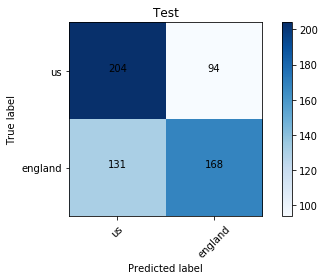

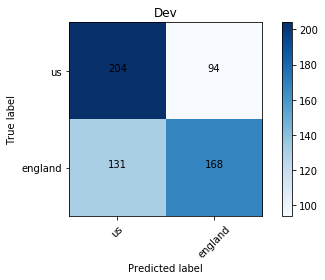

In [154]:
## IVECT ONLY
plot_confusion_matrix(test_cnf_mat, title='Test', classes=accent_dict.values())
plot_confusion_matrix(dev_cnf_mat, title='Dev', classes=accent_dict.values())

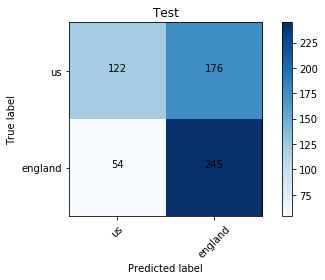

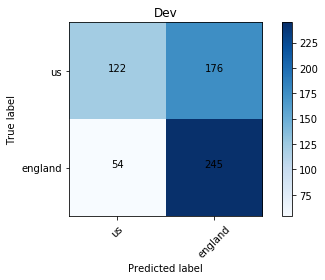

In [52]:
## CONCAT
plot_confusion_matrix(test_cnf_mat, title='Test', classes=accent_dict.values())
plot_confusion_matrix(dev_cnf_mat, title='Dev', classes=accent_dict.values())